# Data Importing

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport

In [29]:
data = pd.read_csv('../All_data_with_exits.csv')
df = pd.DataFrame(data)

In [30]:
df.head()

,2.1 Organization Name,2.2 Project Name,2.4 ProjectType,2.5 Utilization Tracking Method (Invalid),2.6 Federal Grant Programs,5.8 Personal ID,5.9 Household ID,3.15 Relationship to HoH,3.16 Client Location,CaseMembers,...,4.2.10h Workers Compensation,4.2.11i TANF,4.2.12j General Assistance,4.2.13k Retirement (Social Security),4.2.14l Pension from a Former Job,4.2.15m Child Support,4.2.16n Alimony,4.2.17o Other Income,Chronic Homeless Status_vHMISDatAssessment,Chronic Homeless Status_EvaluatevHMIS&HMISDA
0,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,56550,92775,Son,NaN,6,...,0,0,0,0,0,0.0,0,0,0,0
1,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,36138,92775,Self,Spokane City & County CoC,6,...,0,0,0,0,0,0.0,0,0,0,0
2,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,36139,92775,Daughter,NaN,6,...,0,0,0,0,0,0.0,0,0,0,0
3,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,36140,92775,Son,NaN,6,...,0,0,0,0,0,0.0,0,0,0,0
4,Family Promise of Spokane,FPS--ES--Bridges Family Shelter,Emergency shelter,Entry/Exit (e/e),NaN,36141,92775,Significant Other (Non-Married),NaN,6,...,0,0,0,0,0,0.0,0,0,1,1


# Target Recategorization


Because the target is initially recorded in a very granular manner, the target labels will need to be recategorized to fit into the 5 Categories provided by stakeholder:

- Permanent Exit
- Temporary Exit
- Emergency Shelter
- Transitional Housing
- Unknown/Other

**Permanent Exit**

- Staying or living with family, permanent tenure
- Staying or living with friends, permanent tenure
- Permanent housing (other than RRH) for formerly homeless persons
- Rental by client with RRH or equivalent subsidy
- Rental by client, no ongoing housing subsidy
- Rental by client, other ongoing housing subsidy
- Owned by client, no ongoing housing subsidy

**Temporary Exit**  

- Place not meant for habitation (e.g., a vehicle, an abandoned building, bus/train/subway station/airport or anywhere outside)
- Staying or living with family, temporary tenure (e.g., room, apartment or house)
- Staying or living with friends, temporary tenure (e.g., room, apartment or house)
- Hotel or Motel paid for without Emergency Shelter Voucher

**Emergency Shelter**  

- Emergency shelter, including hotel or motel paid for with emergency shelter voucher, or RHY-funded Host Home shelter 

**Transitional Housing**  

- Transitional Housing for homeless persons (including homeless youth)
- Safe Haven
- Substance Abuse Treatment or Detox Center
- Foster Care Home or Foster Care Group Home
- Psychiatric Hospital or Other Psychiatric Facility

**Unknown/Other**

- No exit interview completed
- Client refused
- Other
- Client doesn't know

Because pandas has a built in value mapping function that is more performant and consistent using a dictionary of this format, we are going with this dictionary structure rather than a more DRY dictionary with each entry as an element of a list with the category as the key.  
e.g. `values_dict = {'Permanent Exit' : [some_value, some_value2]}`

In [31]:
# Use apply to assign values in dataframe to categories
values_dict = {
    # Permanent Exits
    'Staying or living with family, permanent tenure' : 'Permanent Exit',
    'Staying or living with friends, permanent tenure' : 'Permanent Exit',
    'Permanent housing (other than RRH) for formerly homeless persons' : 'Permanent Exit',
    'Rental by client with RRH or equivalent subsidy' : 'Permanent Exit',
    'Rental by client, no ongoing housing subsidy' : 'Permanent Exit',
    'Rental by client, other ongoing housing subsidy' : 'Permanent Exit',
    'Owned by client, no ongoing housing subsidy' : 'Permanent Exit',
    # Temporary Exits
    'Place not meant for habitation (e.g., a vehicle, an abandoned building, bus/train/subway station/airport or anywhere outside)' : 'Temporary Exit',
    'Staying or living with family, temporary tenure (e.g., room, apartment or house)' : 'Temporary Exit',
    'Staying or living with friends, temporary tenure (e.g., room, apartment or house)' : 'Temporary Exit',
    'Hotel or Motel paid for without Emergency Shelter Voucher' : 'Temporary Exit',
    # Emergency Shelter
    'Emergency shelter, including hotel or motel paid for with emergency shelter voucher, or RHY-funded Host Home shelter' : 'Emergency Shelter',
    # Transitional Housing
    'Transitional Housing for homeless persons (including homeless youth)' : 'Transitional Housing',
    'Safe Haven' : 'Transitional Housing',
    'Substance Abuse Treatment or Detox Center' : 'Transitional Housing',
    'Foster Care Home or Foster Care Group Home' : 'Transitional Housing',
    'Psychiatric Hospital or Other Psychiatric Facility' : 'Transitional Housing',
    # Unknown/Other
    'No exit interview completed' : 'Unknown/Other',
    'Client refused' : 'Unknown/Other',
    'Other' : 'Unknown/Other',
    'Client doesn\'t know' : 'Unknown/Other',
    np.NaN : 'Unknown/Other'
}

## Cleaning Pipeline

Start and create pipeline

In [32]:
def start_pipeline(dataf):
    '''Creates a copy of original dataframe to use in pipeline'''
    return dataf.copy()

def column_cleaner(dataf):
    '''Takes in a dataframe and removes decimals from column names'''
    dataf.columns = dataf.columns.str.replace(r'\d+.', '')
    return dataf

#Set Data Types function accordingly
def set_dtypes(dataf):
    '''Sets Data Type to specific columns'''
    dataf['Enroll Date'] = pd.to_datetime(dataf['Enroll Date'])
    dataf['Exit Date'] = pd.to_datetime(dataf['Exit Date'])
    return dataf

def add_categories(dataf):
    '''Adds each entry to one of the five target categories'''
    dataf['Recategorized'] = dataf['Exit Destination'].map(values_dict)
    return dataf

Run pipeline

In [33]:
df2 = (df
    .pipe(start_pipeline)
    .pipe(column_cleaner)
    .pipe(set_dtypes)
    .pipe(add_categories)
)

## Pipeline Results Testing

In [34]:
df2['Enroll Date'].dtype, df2['Exit Date'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [35]:
df2['Recategorized'].value_counts(dropna=False)

Permanent Exit          592
Unknown/Other           563
Emergency Shelter       391
Temporary Exit          219
Transitional Housing     97
Name: Recategorized, dtype: int64

## Initial Visualizations  

Final Visualizations will need to be formatted with proper object usage and syntax

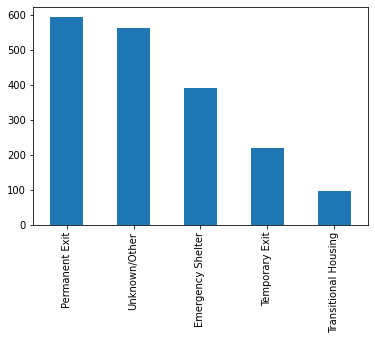

In [46]:
# Value Distribution
df2['Recategorized'].value_counts().plot(kind='bar');

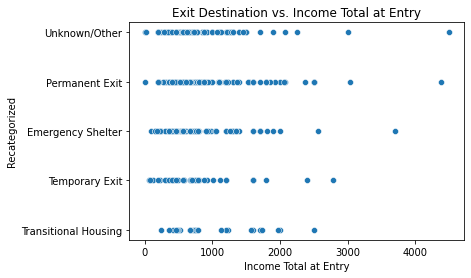

In [40]:
# Basic scatterplots
sns.scatterplot(data=df2, y='Recategorized', x='Income Total at Entry').set_title('Exit Destination vs. Income Total at Entry');